# CNN for MNIST dataset

In [167]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pyplot as plt
import numpy as np

In [168]:
# function for plot_channels to plot kernel paramets 

def plot_channels(W):
    n_out = W.shape[0]
    n_in = W.shape[1]
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(n_out, n_in)
    fig.subplots_adjust(hspace=0.1)
    out_index = 0
    in_index = 0
    
    #plot outputs as rows inputs as columns 
    for ax in axes.flat:
        if in_index > n_in-1:
            out_index = out_index + 1
            in_index = 0
        ax.imshow(W[out_index, in_index, :, :], vmin=w_min, vmax=w_max, cmap='seismic')
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        in_index = in_index + 1

    plt.show()

In [169]:
def plot_parameters(W, number_rows=1, name="", i=0):
    W = W.data[:, i, :, :]
    n_filters = W.shape[0]
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(number_rows, n_filters // number_rows)
    fig.subplots_adjust(hspace=0.4)

    for i, ax in enumerate(axes.flat):
        if i < n_filters:
            # Set the label for the sub-plot.
            ax.set_xlabel("kernel:{0}".format(i + 1))

            # Plot the image.
            ax.imshow(W[i, :], vmin=w_min, vmax=w_max, cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])
    plt.suptitle(name, fontsize=10)    
    plt.show()

In [170]:
# define the function for plotting the activations
def plot_activations(A, number_rows=1, name="", i=0):
    A = A[0, :, :, :].detach().numpy()
    n_activations = A.shape[0]
    A_min = A.min().item()
    A_max = A.max().item()
    fig, axes = plt.subplots(number_rows, n_activations // number_rows)
    fig.subplots_adjust(hspace = 0.9)    

    for i, ax in enumerate(axes.flat):
        if i < n_activations:
            # Set the label for the sub-plot.
            ax.set_xlabel("activation:{0}".format(i + 1))

            # Plot the image.
            ax.imshow(A[i, :], vmin=A_min, vmax=A_max, cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])
    plt.show()

In [171]:
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('y = '+ str(data_sample[1]))

# get the data

In [173]:
IMAGE_SIZE=16
composed = transforms.Compose([transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),transforms.ToTensor()])

In [174]:
train_dataset=dsets.MNIST(root='./data',train=True,download=True,transform=composed)

In [175]:
validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=composed)

In [176]:
#label
train_dataset[4][1]

9

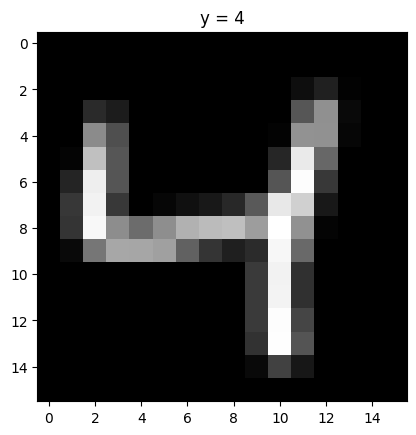

In [177]:
# plot the sample
show_data(train_dataset[2])

# building the convolutional neural network
- 2 layers
- 1 fully connected layer
- output layer
- CNN layer
 - stride 1, padding 0, dilation 1
- Max Pool Layer
  - Stride kernel size padding 0 Dilation:1
    
  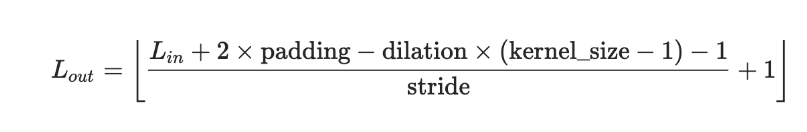

In [179]:
class CNN(nn.Module):
    def __init__(self,out_1=16,out_2=32):
        super(CNN, self).__init__()
        self.cnn1=nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.maxpool1=nn.MaxPool2d(kernel_size=2)

        self.cnn2=nn.Conv2d(in_channels=out_1,out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        #output
        self.fc1=nn.Linear(out_2*4*4,10)

    # prediction
    def forward(self,x):
        x=self.cnn1(x)
        x=torch.relu(x)
        x=self.maxpool1(x)
        x=self.cnn2(x)
        x=torch.relu(x)
        x=self.maxpool2(x)
        x=x.view(x.size(0),-1)
        x=self.fc1(x)
        return x
        
    def activations(self,x):
        z1=self.cnn1(x)
        a1=torch.relu(z1)
        out=self.maxpool1(a1)

        z2=self.cnn2(out)
        a2=torch.relu(z2)
        out1=self.maxpool2(a2)
        out=out.view(out.size(0),-1)
        return z1,a1,z2,a2,out1,out

In [184]:
# defining the convolutional neural network
model=CNN(out_1=16, out_2=32)
model=model.cuda()

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

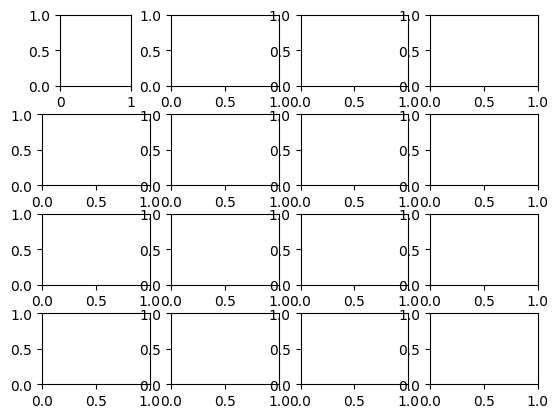

In [185]:
plot_parameters(model.state_dict()['cnn1.weight'], number_rows=4, name='1st layer kernels before training')
plot_parameters(model.state_dict()['cnn2.weight'], number_rows=4, name='2st layer kernels before training')

In [ ]:
# loss function
criterion = nn.CrossEntropyLoss()
learning_rate=0.1
optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate)
train_loader=torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
validation_loader=torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000)

In [197]:
n_epochs=3
cost_list=[]
accuracy_list=[]
N_test=len(validation_dataset)

def train_model(n_epochs):
    for epoch in range(n_epochs):
        COST=0
        
        
        for x, y in train_loader:
            optimizer.zero_grad()
            x=x.cuda()
            y=y.cuda()
            z=model(x)
            loss=criterion(z,y)
            loss.backward()
            optimizer.step()
            COST+=loss.data
        cost_list.append(COST)
        correct=0
        for x_test, y_test in validation_loader:
            x_test=x_test.cuda()
            y_test=y_test.cuda()
            z=model(x_test)
            _,yhat=torch.max(z.data,1)
            correct+=(yhat==y_test).sum().item()
        accuracy=correct/N_test
        accuracy_list.append(accuracy)
        print(f'Epoch number is {epoch} and loss is {loss.item()}')
train_model(n_epochs)

Epoch number is 0 and loss is 2.301370143890381
Epoch number is 1 and loss is 2.301370143890381
Epoch number is 2 and loss is 2.301370143890381


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

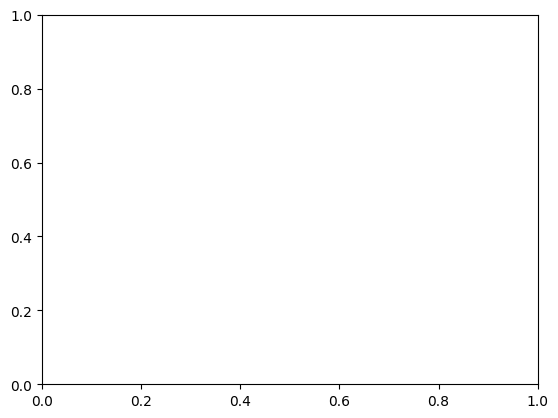

In [198]:
# analyze results
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(cost_list, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color) 
ax2.set_xlabel('epoch', color=color)
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

In [ ]:
plot_channels(model.state_dict()['cnn1.weight'])
plot_channels(model.state_dict()['cnn2.weight'])

In [ ]:
show_data(train_dataset[1])

In [ ]:
out = model.activations(train_dataset[2][0].view(1, 1, IMAGE_SIZE, IMAGE_SIZE))

In [ ]:
# Plot the outputs after the first CNN

plot_activations(out[0], number_rows=4, name="Output after the 1st CNN")

In [ ]:
# Plot the outputs after the first Relu

plot_activations(out[1], number_rows=4, name="Output after the 1st Relu")

In [ ]:
# Plot the outputs after the second CNN

plot_activations(out[2], number_rows=32 // 4, name="Output after the 2nd CNN")

In [ ]:
# Plot the outputs after the second Relu

plot_activations(out[3], number_rows=4, name="Output after the 2nd Relu")

In [ ]:
# Plot the misclassified samples

count = 0
for x, y in torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=1):
    z = model(x)
    _, yhat = torch.max(z, 1)
    if yhat != y:
        show_data((x, y))
        plt.show()
        print("yhat: ",yhat)
        count += 1
    if count >= 5:
        break  